In [1]:
# Import Necessary Packages
import openmc
import numpy as np
from math import pi, sin, cos
import os

# Creates the Necessary Folders
folders = ['inner', 'outer']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
    else:
        print(f"The folder '{folder}' exists")

In [2]:
# ADD MATERIAL DEFINITIONS
# Fuel Material (MOX Fuels)
uranium = openmc.Material() # Depleted Uranium for ALFRED
uranium.add_nuclide('U234', 0.003)
uranium.add_nuclide('U235', 0.404)
uranium.add_nuclide('U236', 0.010)
uranium.add_nuclide('U238', 99.583)

plutonium = openmc.Material()
plutonium.add_nuclide('Pu238', 2.332)
plutonium.add_nuclide('Pu239', 56.873)
plutonium.add_nuclide('Pu240', 26.997)
plutonium.add_nuclide('Pu241', 6.105)
plutonium.add_nuclide('Pu242', 7.693)

oxygen = openmc.Material()
oxygen.add_element('O', 1.0)

uo2 = openmc.Material.mix_materials([uranium, oxygen],[0.3367, 0.6633])
puo2 = openmc.Material.mix_materials([plutonium, oxygen], [0.3367, 0.6633])

mox1 = openmc.Material.mix_materials([puo2, uo2], [0.217, 0.783], 'wo') # 21.7% PuO2 Enrichment
mox2 = openmc.Material.mix_materials([puo2, uo2], [0.278, 0.722], 'wo') # 27.8% PuO2 Enrichment

mox1.set_density('g/cm3', 11.07 * 0.95)    # Setting a density of 0.95 of theoretical density
mox2.set_density('g/cm3', 11.1 * 0.95)     # Setting a density of 0.95 of theoretical density

mox1.temperature = 1200
mox2.temperature = 1200

# Cladding Material (Ti-15-15 Steel)
clad = openmc.Material()
clad.add_element('Cr', 15, 'wo')
clad.add_element('Ni', 15, 'wo')
clad.add_element('Mo', 1.5, 'wo')
clad.add_element('Mn', 1.5, 'wo')
clad.add_element('Si', 0.9, 'wo')
clad.add_element('Ti', 0.4, 'wo')
clad.add_element('C', 0.09, 'wo')
clad.add_element('B', 0.006, 'wo')
clad.add_element('Fe', 65.604,'wo')
clad.set_density('g/cm3', 7.95)
clad.temperature = 900

# Coolant (Lead)
lead = openmc.Material()
lead.add_element('Pb', 1.0,)
lead.temperature = 700
lead.set_density('g/cm3', 10.6)
lead.depletable = True
lead.volume = 6134682.08   

# Gap (Helium)
he = openmc.Material()
he.add_element('He', 1)
he.set_density('g/cm3', 0.00016)
he.temperature= 700
 
# Absorber (Boron Carbide)
b4c = openmc.Material()
b4c.add_element('B', 4.0, enrichment=90, enrichment_target='B10', enrichment_type='wo')
b4c.add_element('C', 1.0)
b4c.set_density('g/cm3', 2.2)
b4c.temperature = 700

# Reflector (Yttria-Stabilized Zirconia)
zirconia = openmc.Material()
zirconia.add_elements_from_formula('ZrO2', 'ao', 1.0)

yttria = openmc.Material()
yttria.add_elements_from_formula('Y2O3', 'ao', 1.0)

ysz = openmc.Material.mix_materials([zirconia, yttria], [0.95, 0.05], 'wo')
ysz.temperature = 700
ysz.set_density('g/cm3', 6.08)

mat = openmc.Materials([mox1, mox2, clad, he, lead, b4c, ysz])
mat.export_to_xml("./inner/materials.xml")
mat.export_to_xml("./outer/materials.xml")

In [3]:
# ADD PRIMARY GEOMETRY DEFINITIONS
# Surfaces
fuel_ir = openmc.ZCylinder(r=0.1)
fuel_or = openmc.ZCylinder(r=0.45)
clad_ir = openmc.ZCylinder(r=0.465)
clad_or = openmc.ZCylinder(r=0.525)

top = openmc.ZPlane(z0=+30)
bottom = openmc.ZPlane(z0=-30)
cr_top = openmc.ZPlane(z0=-24)
cr_down = openmc.ZPlane(z0=-84.5)
up = openmc.ZPlane(z0=+42, boundary_type='vacuum')
down = openmc.ZPlane(z0=-85, boundary_type='vacuum')

# Regions
center_region = -fuel_ir & -up & +down
fuel_region = +fuel_ir & -fuel_or & -top & +bottom
gap_region = +fuel_or & -clad_ir & -top & +bottom
clad_region = +clad_ir & -clad_or & -top & +bottom
coolant_region = +clad_or & -up & +down

# Define Inner Assembly Fuel Pins
center_cell1 = openmc.Cell(region=center_region)
fuel_cell1 = openmc.Cell(fill=mox1, region=fuel_region)
gap_cell1 = openmc.Cell(fill=he, region=gap_region)
clad_cell1 = openmc.Cell(fill=clad, region=clad_region)
coolant_cell1 = openmc.Cell(fill=lead, region=coolant_region)

fuel_u1 = openmc.Universe(cells=[center_cell1, fuel_cell1, gap_cell1, clad_cell1, coolant_cell1])

# Define Inner Fuel Assembly
all_lead_out = openmc.Cell(fill=lead)
all_lead_out_u = openmc.Universe(cells=[all_lead_out])
in_lat = openmc.HexLattice(name='inner_fuel_assembly')
in_lat.center = (0., 0.)
in_lat.pitch = (1.386,)
in_lat.outer = all_lead_out_u

in_ring6 = [fuel_u1]*36
in_ring5 = [fuel_u1]*30
in_ring4 = [fuel_u1]*24
in_ring3 = [fuel_u1]*18
in_ring2 = [fuel_u1]*12
in_ring1 = [fuel_u1]*6
in_ring0 = [fuel_u1]

in_lat.universes = [in_ring6, in_ring5, in_ring4, in_ring3, in_ring2, in_ring1, in_ring0]
in_lat.orientation = 'y'

outer_in_surface = openmc.model.HexagonalPrism(edge_length=9.0, orientation='y')

main_in_assembly = openmc.Cell(fill=in_lat, region=-outer_in_surface & -top & +bottom)

in_plenum_top = openmc.Cell(fill=lead, region= -outer_in_surface & -up & +top)
in_plenum_bottom = openmc.Cell(fill=lead, region= -outer_in_surface & +down & -bottom)

out_in_assembly = openmc.Cell(fill=lead, region=+outer_in_surface & -up & +down)

main_in_u = openmc.Universe(cells=[main_in_assembly, out_in_assembly, in_plenum_bottom, in_plenum_top])

# Define Outer Assembly Fuel Pins
center_cell2 = openmc.Cell(region=center_region)
fuel_cell2 = openmc.Cell(fill=mox2, region=fuel_region)
gap_cell2 = openmc.Cell(fill=he, region=gap_region)
clad_cell2 = openmc.Cell(fill=clad, region=clad_region)
coolant_cell2 = openmc.Cell(fill=lead, region=coolant_region)

fuel_u2 = openmc.Universe(cells=[center_cell2, fuel_cell2, gap_cell2, clad_cell2, coolant_cell2])

# Define Outer Fuel Assembly
out_lat = openmc.HexLattice(name='assembly')
out_lat.center = (0., 0.)
out_lat.pitch = (1.386,)
out_lat.outer=all_lead_out_u
out_lat.orientation = 'y'

out_ring6 = [fuel_u2]*36
out_ring5 = [fuel_u2]*30
out_ring4 = [fuel_u2]*24
out_ring3 = [fuel_u2]*18
out_ring2 = [fuel_u2]*12
out_ring1 = [fuel_u2]*6
out_ring0 = [fuel_u2]

out_lat.universes = [out_ring6, out_ring5, out_ring4, out_ring3, out_ring2, out_ring1, out_ring0]

outer_out_surface = openmc.model.HexagonalPrism(edge_length=9, orientation='y')

main_out_assembly = openmc.Cell(fill=out_lat, region=-outer_out_surface & -top & +bottom)

out_plenum_top = openmc.Cell(fill=lead, region=-outer_out_surface & -up & +top)
out_plenum_bottom = openmc.Cell(fill=lead, region=-outer_out_surface & +down & -bottom)

out_out_assembly = openmc.Cell(fill=lead, region=+outer_out_surface & -up & +down)

main_out_u = openmc.Universe(cells=[main_out_assembly, out_out_assembly, out_plenum_bottom, out_plenum_top])

# Define Shutdown Rod
outer_sr_surface = openmc.model.HexagonalPrism(edge_length=9, orientation='y')
sr_cell = openmc.Cell(fill=lead, region=-outer_sr_surface & -up & +down)
out_sr_cell = openmc.Cell(fill=lead, region=+outer_sr_surface & -up & +down)
sr_u = openmc.Universe(cells=[sr_cell, out_sr_cell])

# Define Control Rod

calendria_ir = 6.44780
calendria_or = 6.58750
r_rod = 1.48
r_clad = 1.53

ring_radii = np.array([0.0, 3.2, 6.2])

# These are the surfaces that will divide each of the rings
radial_surf = [openmc.ZCylinder(r=r) for r in
               (ring_radii[:-1] + ring_radii[1:])/2]

lead_cells = []
for i in range(ring_radii.size):
    # Create annular region
    if i == 0:
        lead_region = -radial_surf[i]  & -up & +down
    elif i == ring_radii.size - 1:
        lead_region = +radial_surf[i-1]  & -up & +down
    else:
        lead_region = +radial_surf[i-1] & -radial_surf[i]  & -up & +down
        
    lead_cells.append(openmc.Cell(fill=lead, region=lead_region  & -up & +down))

cr_u = openmc.Universe(cells=lead_cells)

# Pin Universe
surf_rod = openmc.ZCylinder(r=r_rod)

rod_cell = openmc.Cell(fill=b4c, region=-surf_rod & -cr_top & +cr_down)
clad_cell = openmc.Cell(fill=clad, region=+surf_rod  & -cr_top & +cr_down)

pin_universe = openmc.Universe(cells=(rod_cell, clad_cell))

num_pins = [1, 6, 12]
angles = [0, 30, 15]

cr_top_cell=openmc.Cell(fill=lead, region=-up & +cr_top)
cr_down_cell=openmc.Cell(fill=lead, region=+down & -cr_down)
cr_cyl_ir = openmc.ZCylinder(r=8)
cr_cyl_or = openmc.ZCylinder(r=8.5)

for i, (r, n, a) in enumerate(zip(ring_radii, num_pins, angles)):
    for j in range(n):
        # Determine the location of center of pin
        theta = (a + j/n*360.) * pi/180.
        x = r*cos(theta)
        y = r*sin(theta)
        
        pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_clad)
        lead_cells[i].region &= +pin_boundary  
        
        # Create each fuel pin -- note that we explicitly assign an ID so 
        # that we can identify the pin later when looking at tallies
        pin = openmc.Cell(fill=pin_universe, region=-pin_boundary & -cr_top & +cr_down)
        pin.translation = (x, y, 0)
        pin.id = (i + 1)*100 + j
        cr_u.add_cell(pin)
        cr_u.add_cell(cr_top_cell)
        cr_u.add_cell(cr_down_cell) 

# Define Dummy/Reflector
outer_dummy_surface = openmc.model.HexagonalPrism(edge_length=9, orientation='y')
dummy_cell = openmc.Cell(fill=ysz, region=-outer_dummy_surface & -up & +down)
out_dummy_cell = openmc.Cell(fill=lead, region=+outer_dummy_surface & -up & +down)
dummy_u = openmc.Universe(cells=[dummy_cell, out_dummy_cell])

# Empty
outer_empty_surface = openmc.model.HexagonalPrism(edge_length=9, orientation='y')
empty_cell = openmc.Cell(fill=lead, region= None)
out_empty_cell = openmc.Cell(region= None)
empty_u = openmc.Universe(cells=[empty_cell,out_empty_cell])

# Define Core Geometry
core_lat = openmc.HexLattice(name='core')
core_lat.center = (0., 0.)
core_lat.pitch = (16.6,)
core_lat.outer = all_lead_out_u
core_lat.orientation = 'x'

core_ring10 =  ([empty_u]*3 + [dummy_u]*5 + [empty_u]*2)*6
core_ring9 = ([empty_u] + [dummy_u]*8)*6
core_ring8 = ([dummy_u]*3 + [main_out_u]*3 + [dummy_u]*2 )*6 
core_ring7 = [main_out_u]*42
core_ring6 = [main_out_u, main_out_u, cr_u, main_out_u, cr_u, main_out_u]*6
core_ring5 = [main_out_u]*30
core_ring4 = [main_in_u]*24
core_ring3 = [main_in_u]*18
core_ring2 = [sr_u, main_in_u, main_in_u]*4
core_ring1 = [main_in_u]*6
core_ring0 = [main_in_u]*1
core_lat.universes = [core_ring10, core_ring9, core_ring8, core_ring7, core_ring6, core_ring5, core_ring4, core_ring3, core_ring2, core_ring1, core_ring0]

outer_core_surface = openmc.ZCylinder(r=160, boundary_type='vacuum')

core = openmc.Cell(fill=core_lat, region=-outer_core_surface & -up & +down)

main_u = openmc.Universe(cells=[core])

geom = openmc.Geometry(main_u)
geom.export_to_xml("./inner/geometry.xml")
geom.export_to_xml("./outer/geometry.xml")

In [4]:
# Settings
# Used variables for better usability in getting tallies from values
number_of_batches = 30
number_of_particles = 10000

settings = openmc.Settings()
settings.temperature = {'method':'interpolation'}
settings.batches = number_of_batches
settings.inactive = 8
settings.particles = number_of_particles
settings.export_to_xml("./inner/settings.xml")
settings.export_to_xml("./outer/settings.xml")

In [5]:
# Tallies
H = openmc.Tally(tally_id=1)
H.scores = ['heating-local']

# Iterating over folders and assemblies to get tallies.xml files
assemblies = [main_in_assembly, main_out_assembly]
tally_ids = [6, 28]   # 6 for inner, 28 for outer

for folder, assembly, tally_id in zip(folders, assemblies, tally_ids):
    tally = openmc.Tally(tally_id=tally_id)
    tally.filters = [openmc.DistribcellFilter(assembly)]
    tally.scores = ['fission']
    
    tallies = openmc.Tallies([tally,H])
    tallies.export_to_xml(f"./{folder}/tallies.xml")

In [6]:
# We're ready to run the transport simulation and get tally results to plot.
for folder in folders:
    
    # We're ready to run the transport simulation and get tally results to plot.
    openmc.run(cwd=f'./{folder}/')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [7]:
# Now that the simulation is finished, we need to pull the resulting data

# Saving Data for Inner Assembly
sp_inner = openmc.StatePoint(f'./inner/statepoint.{number_of_batches}.h5')
t_inner = sp_inner.tallies[tally_ids[0]]                                        # Get the Tally object
df_inner = t_inner.get_pandas_dataframe()                                       # Show a Pandas dataframe
H_value_inner = sp_inner.tallies[H.id].get_pandas_dataframe()['mean'][0]        # H Value for normalization

# Saving Data for Outer Assembly
sp_outer = openmc.StatePoint(f'./outer/statepoint.{number_of_batches}.h5')
t_outer = sp_outer.tallies[tally_ids[1]]                                        # Get the Tally object
df_outer = t_outer.get_pandas_dataframe()                                       # Show a Pandas dataframe
H_value_outer = sp_outer.tallies[H.id].get_pandas_dataframe()['mean'][0]        # H Value for normalization

# Free the Memory
sp_inner.close()
sp_outer.close()

In [8]:
# Calculating the Q Values
inner_pu_enrichment = 21.7
outer_pu_enrichment = 27.8

Q_PuO2 = 209    # Roughly
Q_UO2 = 200

energy_rpf_inner = (inner_pu_enrichment * Q_PuO2 + (100 - inner_pu_enrichment) * Q_UO2) / 100
energy_rpf_outer = (outer_pu_enrichment * Q_PuO2 + (100 - outer_pu_enrichment) * Q_UO2) / 100

# Calculating the Factors to Normalize the Flux
core_power = 300e6                                                # J/s
H_Jsrc_inner = 1.602e-19 * H_value_inner                          # J/src
H_Jsrc_outer = 1.602e-19 * H_value_outer                          # J/src

fission_normalization_factor_inner = core_power / H_Jsrc_inner    # src/s
fission_normalization_factor_outer = core_power / H_Jsrc_outer    # src/s

In [9]:
# Normalizing Inner Assemblies' Power Output Values
normalized_df_inner = df_inner
normalized_df_inner['mean'] = df_inner['mean'] * fission_normalization_factor_inner * energy_rpf_inner * 1.602e-19 # in MW

inner_df = normalized_df_inner['level 2']['lat'][['x', 'y']]
inner_df['Power (MW)'] = normalized_df_inner['mean']
inner_df['Std. Dev.'] = normalized_df_inner['std. dev.']

print('Inner FAs:', inner_df.describe(), sep="\n")

# Normalizing Outer Assemblies' Power Output Values
normalized_df_outer = df_outer
normalized_df_outer['mean'] = df_outer['mean'] * fission_normalization_factor_outer * energy_rpf_outer * 1.602e-19 # in MW

outer_df = normalized_df_outer['level 2']['lat'][['x', 'y']]
outer_df['Power (MW)'] = normalized_df_outer['mean']
outer_df['Std. Dev.'] = normalized_df_outer['std. dev.']

print('Outer FAs:', outer_df.describe(), sep="\n")

Inner FAs:
               x          y  Power (MW)  Std. Dev.
count  57.000000  57.000000   57.000000  57.000000
mean    0.000000   0.000000    2.009391   0.000064
std     2.427521   2.434866    0.129910   0.000018
min    -4.000000  -4.000000    1.693763   0.000029
25%    -2.000000  -2.000000    1.924293   0.000049
50%     0.000000   0.000000    2.000965   0.000062
75%     2.000000   2.000000    2.105096   0.000075
max     4.000000   4.000000    2.280495   0.000105
Outer FAs:
                x           y  Power (MW)   Std. Dev.
count  114.000000  114.000000  114.000000  114.000000
mean     0.000000    0.000000    1.600321    0.000052
std      4.844484    4.844484    0.329248    0.000011
min     -8.000000   -8.000000    1.046413    0.000029
25%     -5.000000   -5.000000    1.339975    0.000044
50%      0.000000    0.000000    1.493181    0.000050
75%      5.000000    5.000000    1.863042    0.000061
max      8.000000    8.000000    2.259795    0.000085


In [10]:
# Saving the Values in csv Files
inner_df.to_csv('./inner_FAs.csv')
outer_df.to_csv('./outer_FAs.csv')


       +===================================================+
       |            _      ____     __  __    ___          |
       |           / \    |  _ \   |  \/  |  |_ _|         |
       |          / _ \   | |_) |  | |\/| |   | |          |
       |         / ___ \  |  _ <   | |  | |   | |          |
       |        /_/   \_\ |_| \_\  |_|  |_|  |___|         |
       |        Advanced  Reactor  Modeling Interface      |
       |                                                   |
       |                    version 0.5.1                  |
       |                                                   |
       +===================================================+


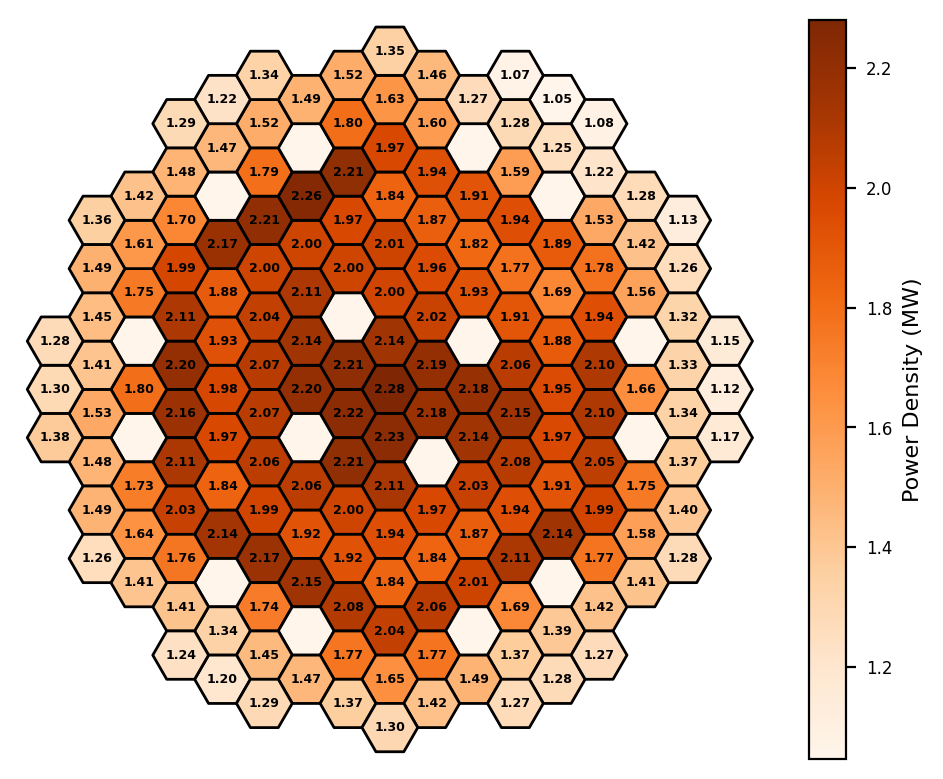

In [11]:
# Plotting the Power Values
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import pandas as pd
from armi import configure
from armi.reactor import grids

configure(permissive=True)

# Create hex grid with 1.0 cm pitch
hexes = grids.HexGrid.fromPitch(1.0)

# Load data from CSV files
inner_data = pd.read_csv("./inner_FAs.csv")
outer_data = pd.read_csv("./outer_FAs.csv")

# Combine data into a single dictionary of (i, j) to power values
power_values = {(row['x'], row['y']): row['Power (MW)'] for _, row in pd.concat([inner_data, outer_data]).iterrows()}

# Generate power list for color mapping
power_list = [power for power in power_values.values()]

plt.rcParams.update({
    "font.weight": "bold"
})

polys = []
fig, ax = plt.subplots(dpi=200)
ax.set_aspect("equal")
ax.set_axis_off()
assembly_numbers = 187

for hex_i in hexes.generateSortedHexLocationList(assembly_numbers):
    x, y, z = hex_i.getGlobalCoordinates()
    i, j = hex_i.i, hex_i.j
    if (i, j) in power_values:
        power = power_values[(i, j)]
        ax.text(x, y, f"{power:.2f}", ha="center", va="center", fontsize=4.5)
        polys.append(mpatches.RegularPolygon((x, y), numVertices=6, radius=1 / math.sqrt(3), orientation=math.pi / 2))
    else:
        polys.append(mpatches.RegularPolygon((x, y), numVertices=6, radius=1 / math.sqrt(3), orientation=math.pi / 2, facecolor='white', edgecolor='k'))

# Use raw power values for color mapping with a custom normalization
min_power = min(power_list) if power_list else 0
max_power = max(power_list) if power_list else 1
norm = plt.Normalize(min_power, max_power)
power_colors = [power_values.get((i, j), 0) for i, j in [(hex_i.i, hex_i.j) for hex_i in hexes.generateSortedHexLocationList(assembly_numbers)]]

patches = PatchCollection(polys, facecolors=plt.cm.Oranges(norm(power_colors)) if power_list else ['white'], ec='k')

ax.add_collection(patches)

# Create a bounding box around patches with a small margin (2%)
bbox = patches.get_datalim(ax.transData)
bbox = bbox.expanded(1.02, 1.02)
ax.set_xlim(bbox.xmin, bbox.xmax)
ax.set_ylim(bbox.ymin, bbox.ymax)

patches.set_array(np.array(power_colors))
patches.set_cmap(plt.cm.Oranges)
patches.set_norm(norm)
cbar = plt.colorbar(patches, ax=ax)
cbar.set_label("Power Density (MW)", fontsize=8, fontweight="normal")

cbar.ax.tick_params(labelsize=6)
for ticklabel in cbar.ax.get_yticklabels():
    ticklabel.set_fontweight("normal")

plt.show()